In [1]:
import os
import zipfile

# Ensure Kaggle API credentials are in place
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    f.write('{"username":"YOUR_USERNAME","key":"YOUR_KEY"}')

# Download the dataset from Kaggle
!kaggle datasets download -d emmarex/plantdisease

# Unzip the downloaded dataset
with zipfile.ZipFile('plantdisease.zip', 'r') as zip_ref:
    zip_ref.extractall('PlantVillage')

# Remove the zip file
os.remove('plantdisease.zip')


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 652M/658M [00:07<00:00, 49.2MB/s]
100% 658M/658M [00:07<00:00, 94.7MB/s]


In [2]:
!pip install tensorflow numpy pandas opencv-python scikit-learn

In [3]:
pip install numpy opencv-python scikit-learn pywavelets scikit-image


In [4]:


import cv2
import numpy as np
import pywt
from sklearn.decomposition import PCA
from skimage.feature import greycomatrix, greycoprops

# Step 1: Histogram Equalization
def histogram_equalization(image):
    if len(image.shape) == 3:
        img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    else:
        image = cv2.equalizeHist(image)
    return image

# Step 2: K-means Clustering
def kmeans_clustering(image, k=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    _, labels, centers = cv2.kmeans(pixel_values, k, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

# Step 3: Contour Tracing
def contour_tracing(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Step 4: Discrete Wavelet Transform (DWT)
def dwt(image):
    coeffs2 = pywt.dwt2(image, 'bior1.3')
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH

# Step 5: Principal Component Analysis (PCA)
def apply_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)
    return principal_components

# Step 6: Gray-Level Co-occurrence Matrix (GLCM)
def glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')
    dissimilarity = greycoprops(glcm, 'dissimilarity')
    homogeneity = greycoprops(glcm, 'homogeneity')
    energy = greycoprops(glcm, 'energy')
    correlation = greycoprops(glcm, 'correlation')
    return contrast, dissimilarity, homogeneity, energy, correlation

# Apply preprocessing to dataset
import os
from glob import glob

dataset_path = '/content/PlantVillage'
image_files = glob(os.path.join(dataset_path, '*.jpg'))

preprocessed_data = []

for file in image_files:
    image = cv2.imread(file)
    # Step 1: Histogram Equalization
    image = histogram_equalization(image)
    # Step 2: K-means Clustering
    image = kmeans_clustering(image)
    # Step 3: Contour Tracing
    contours = contour_tracing(image)
    # Step 4: Discrete Wavelet Transform (DWT)
    LL, LH, HL, HH = dwt(image)
    # Step 5: Principal Component Analysis (PCA)
    image_reshaped = LL.reshape(-1, LL.shape[2])
    pca_features = apply_pca(image_reshaped)
    # Step 6: Gray-Level Co-occurrence Matrix (GLCM)
    contrast, dissimilarity, homogeneity, energy, correlation = glcm_features(image)

    # Collecting all features
    features = np.hstack((pca_features.flatten(), contrast.flatten(), dissimilarity.flatten(),
                          homogeneity.flatten(), energy.flatten(), correlation.flatten()))

    preprocessed_data.append(features)

# Convert to numpy array
preprocessed_data = np.array(preprocessed_data)


In [5]:
# Define all hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 75
CLASS_NAMES = [
    'Pepper__bell___Bacterial_spot',
    'Pepper__bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy',
]

In [6]:
import tensorflow as tf
import os
import shutil

# Define all hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 500

# Define the class names you want to keep
DESIRED_CLASS_NAMES = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy',
]

# Load dataset
dataset_dir = "/content/PlantVillage/PlantVillage"
new_dataset_dir = "/content/Filtered_PlantVillage"

# Create new dataset directory
if os.path.exists(new_dataset_dir):
    shutil.rmtree(new_dataset_dir)
os.makedirs(new_dataset_dir)

# Create subdirectories for each desired class
for class_name in DESIRED_CLASS_NAMES:
    os.makedirs(os.path.join(new_dataset_dir, class_name))

# Load the full dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,  # Load all classes initially
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)

dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,  # Load all classes initially
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

# Get the class indices
class_indices = {name: index for index, name in enumerate(dataset.class_names)}
desired_class_indices = [class_indices[name] for name in DESIRED_CLASS_NAMES]

# Function to filter and remap dataset
def filter_and_remap_classes(dataset, desired_class_indices):
    def class_filter(image, label):
        is_desired_class = tf.reduce_any(tf.equal(label, desired_class_indices))
        new_label = tf.where(tf.equal(desired_class_indices, label))[0][0]
        return image, tf.cast(new_label, tf.int32)

    dataset = dataset.unbatch()
    dataset = dataset.filter(lambda image, label: tf.reduce_any(tf.equal(label, desired_class_indices)))
    dataset = dataset.map(class_filter, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

# Filter and remap the datasets
dataset_filtered = filter_and_remap_classes(dataset, desired_class_indices)
dataset_val_filtered = filter_and_remap_classes(dataset_val, desired_class_indices)

# Define filtered class names
filtered_class_names = [dataset.class_names[i] for i in desired_class_indices]

print(f"Filtered class names: {filtered_class_names}")

# Save filtered dataset to new directory
def save_filtered_dataset(dataset, base_dir):
    for images, labels in dataset:
        for image, label in zip(images, labels):
            class_name = filtered_class_names[label]
            class_dir = os.path.join(base_dir, class_name)
            image_count = len(os.listdir(class_dir))
            image_path = os.path.join(class_dir, f"{image_count}.jpg")
            tf.keras.preprocessing.image.save_img(image_path, image.numpy())

save_filtered_dataset(dataset_filtered, new_dataset_dir)
save_filtered_dataset(dataset_val_filtered, new_dataset_dir)

print(f"Filtered dataset saved to {new_dataset_dir}")


Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Filtered class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Filtered dataset saved to /content/Filtered_PlantVillage


Found 16011 images belonging to 10 classes.

Fold 1/5
Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                        

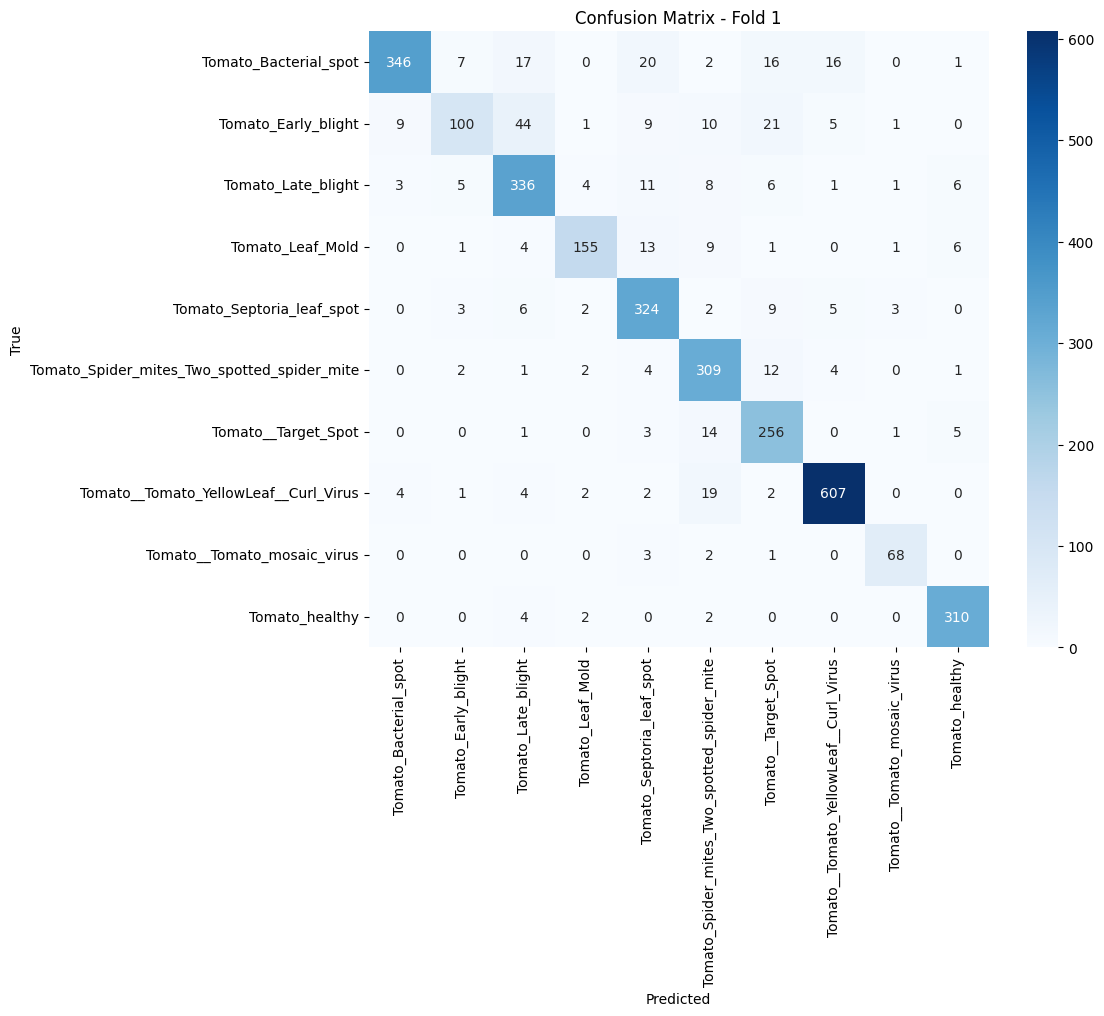


Fold 2/5
Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                       

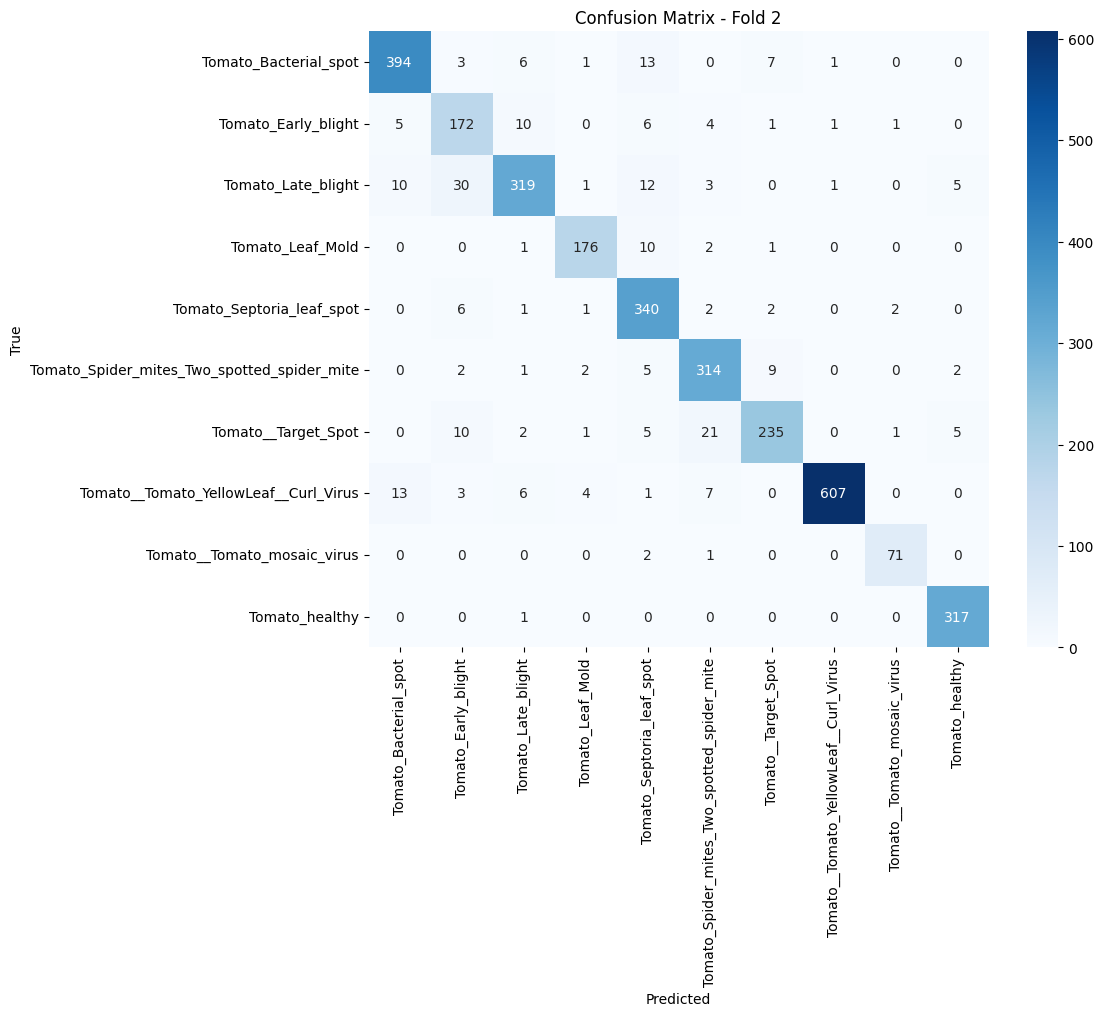


Fold 3/5
Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                       

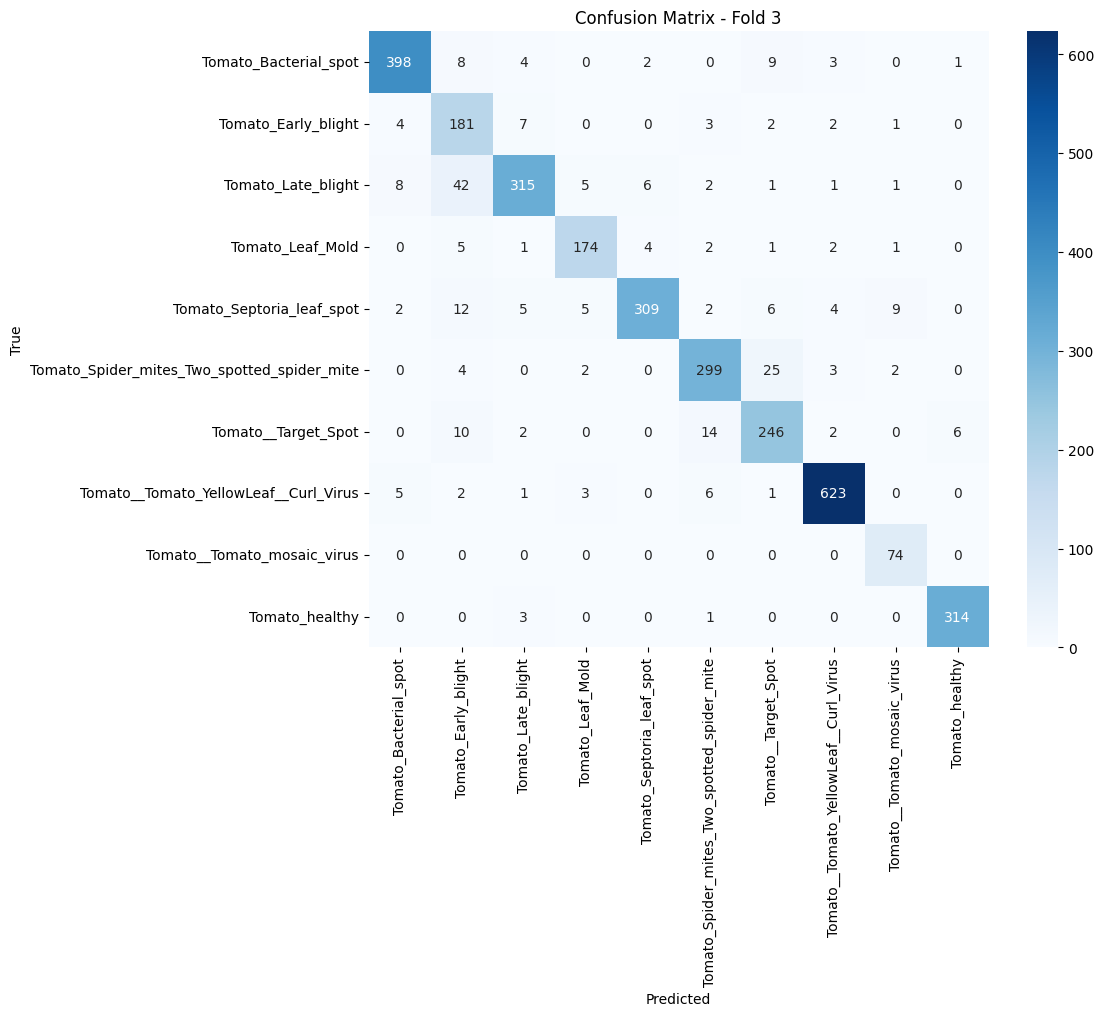


Fold 4/5
Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                       

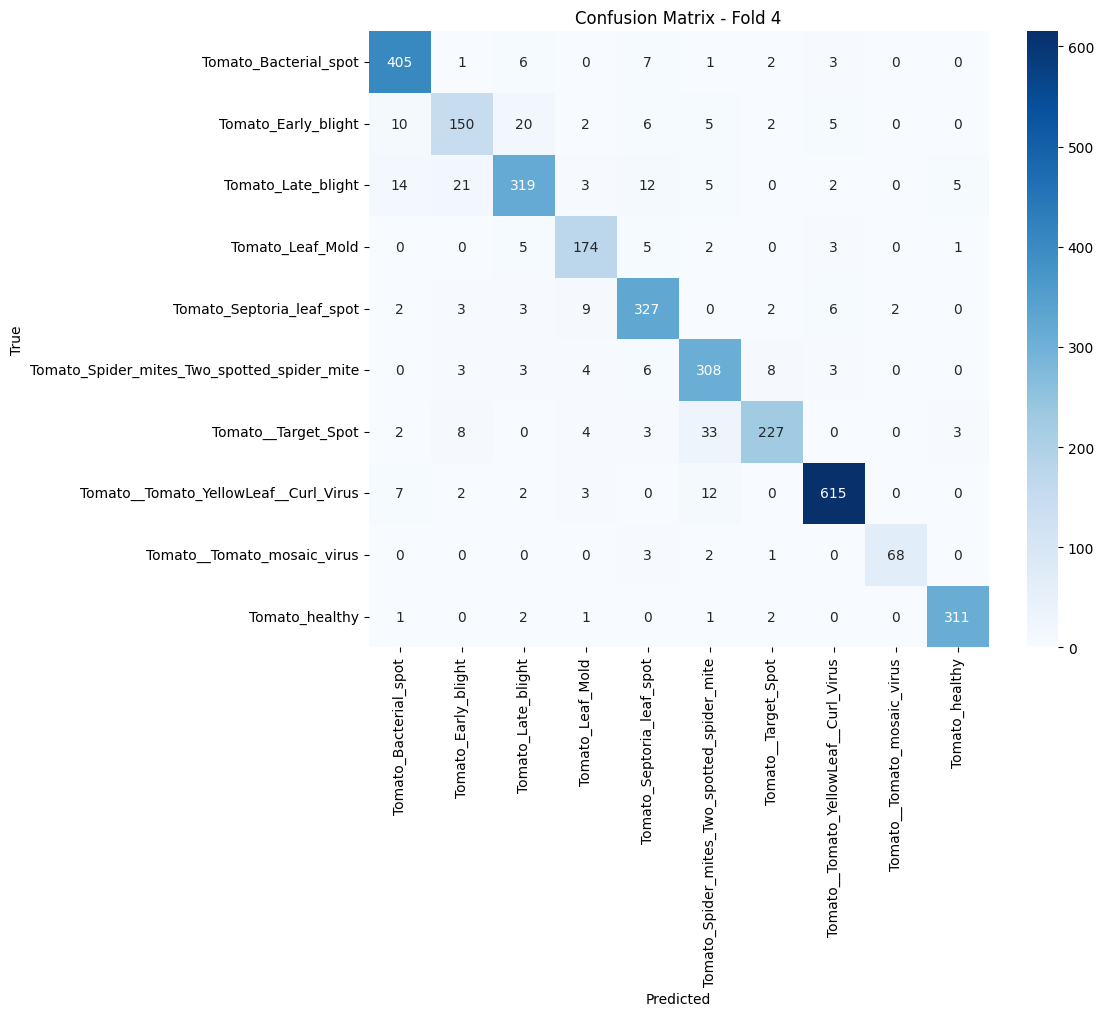


Fold 5/5
Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_5 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                       

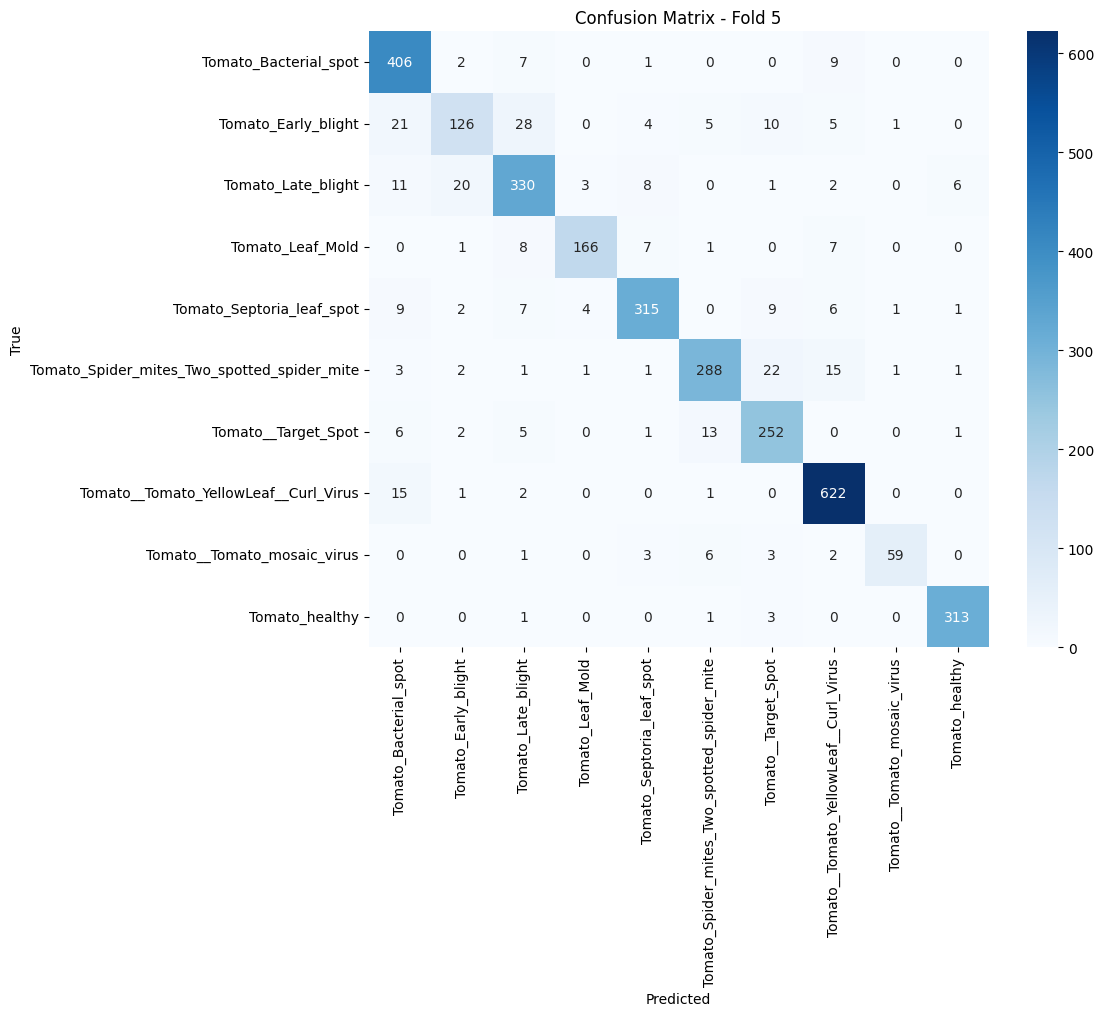


Average Metrics across 5 Folds:
  Accuracy: 0.9042
  Precision: 0.9077
  Recall: 0.9049
  F1 Score: 0.9043
  AUC: 0.9942


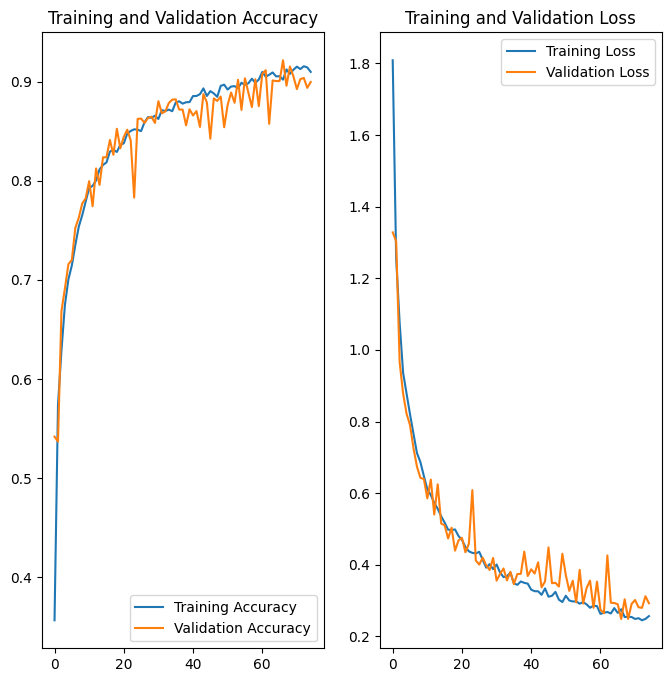

In [8]:
# Install necessary libraries
!pip install tensorflow_model_optimization

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import os
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define all hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 75
NUM_FOLDS = 5
CLASS_NAMES = [
    'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
    'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'
]
n_classes = len(CLASS_NAMES)

# Load dataset
dataset_dir = "/content/Filtered_PlantVillage"

# Create ImageDataGenerator
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    validation_split=0.2
)

# Load all data for splitting
dataset = image_gen.flow_from_directory(
    dataset_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    classes=CLASS_NAMES
)

# Prepare KFold cross-validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Function to create and compile the custom CNN model
def create_model():
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

# Variables to store the results
all_fold_histories = []
all_fold_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "auc": []
}

# 5-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(np.zeros(dataset.samples))):
    print(f"\nFold {fold + 1}/{NUM_FOLDS}")

    # Create data generators for this fold
    train_gen = image_gen.flow_from_directory(
        dataset_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        classes=CLASS_NAMES
    )
    val_gen = image_gen.flow_from_directory(
        dataset_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        classes=CLASS_NAMES
    )

    # Create and compile the model
    model = create_model()

    # Print model summary
    model.summary()

    # Train the model
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        verbose=1
    )
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training Time for fold {fold + 1}: {training_time:.2f} seconds")

    all_fold_histories.append(history.history)

    # Save model weights
    model.save_weights('/content/model_weights.h5')
    # Evaluate the model
    val_steps = val_gen.samples // BATCH_SIZE
    scores = model.evaluate(val_gen, steps=val_steps, verbose=1)
    val_accuracy = scores[1]

    # Get predictions and labels
    y_pred = []
    y_true = []
    y_pred_prob = []

    for images, labels in val_gen:
        y_true.extend(np.argmax(labels, axis=1))  # Ensure labels are in the correct format
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_pred_prob.extend(predictions)

        if len(y_true) >= val_gen.samples:
            break

    y_pred_prob = np.array(y_pred_prob)

    # Compute metrics
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(CLASS_NAMES)):
        fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    average_auc = np.mean(list(roc_auc.values()))

    # Store metrics
    all_fold_metrics["accuracy"].append(val_accuracy)
    all_fold_metrics["precision"].append(precision)
    all_fold_metrics["recall"].append(recall)
    all_fold_metrics["f1"].append(f1)
    all_fold_metrics["auc"].append(average_auc)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.show()

# Calculate average metrics across all folds
avg_accuracy = np.mean(all_fold_metrics["accuracy"])
avg_precision = np.mean(all_fold_metrics["precision"])
avg_recall = np.mean(all_fold_metrics["recall"])
avg_f1 = np.mean(all_fold_metrics["f1"])
avg_auc = np.mean(all_fold_metrics["auc"])

print(f"\nAverage Metrics across {NUM_FOLDS} Folds:")
print(f"  Accuracy: {avg_accuracy:.4f}")
print(f"  Precision: {avg_precision:.4f}")
print(f"  Recall: {avg_recall:.4f}")
print(f"  F1 Score: {avg_f1:.4f}")
print(f"  AUC: {avg_auc:.4f}")

# Plot accuracy and loss curves for the last fold
acc = all_fold_histories[-1]['accuracy']
val_acc = all_fold_histories[-1]['val_accuracy']
loss = all_fold_histories[-1]['loss']
val_loss = all_fold_histories[-1]['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
